In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/student-grade-prediction/student-mat.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score, roc_curve

In [3]:
df = pd.read_csv('/kaggle/input/student-grade-prediction/student-mat.csv')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [5]:
pd.isna(df).any()

school        False
sex           False
age           False
address       False
famsize       False
Pstatus       False
Medu          False
Fedu          False
Mjob          False
Fjob          False
reason        False
guardian      False
traveltime    False
studytime     False
failures      False
schoolsup     False
famsup        False
paid          False
activities    False
nursery       False
higher        False
internet      False
romantic      False
famrel        False
freetime      False
goout         False
Dalc          False
Walc          False
health        False
absences      False
G1            False
G2            False
G3            False
dtype: bool

In [6]:
(df[['G1', 'G2', 'G3']] == 0).any()

G1    False
G2     True
G3     True
dtype: bool

In [7]:
df = df[(df['G2'] != 0) & (df['G3'] != 0)]
(df[['G2', 'G3']] == 0).any()

G2    False
G3    False
dtype: bool

In [8]:
encoder = OneHotEncoder(sparse=False, drop='first')
cat_cols = df.select_dtypes(include=['object']).columns
cat_df = pd.DataFrame(encoder.fit_transform(df[cat_cols]), columns=encoder.get_feature_names_out(cat_cols))
cat_df.index = df.index
cat_df = cat_df.astype(bool)
num_df = df.drop(columns=cat_cols)
df_encoded = pd.concat([num_df, cat_df], axis=1)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 357 entries, 0 to 394
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                357 non-null    int64
 1   Medu               357 non-null    int64
 2   Fedu               357 non-null    int64
 3   traveltime         357 non-null    int64
 4   studytime          357 non-null    int64
 5   failures           357 non-null    int64
 6   famrel             357 non-null    int64
 7   freetime           357 non-null    int64
 8   goout              357 non-null    int64
 9   Dalc               357 non-null    int64
 10  Walc               357 non-null    int64
 11  health             357 non-null    int64
 12  absences           357 non-null    int64
 13  G1                 357 non-null    int64
 14  G2                 357 non-null    int64
 15  G3                 357 non-null    int64
 16  school_MS          357 non-null    bool 
 17  sex_M              35

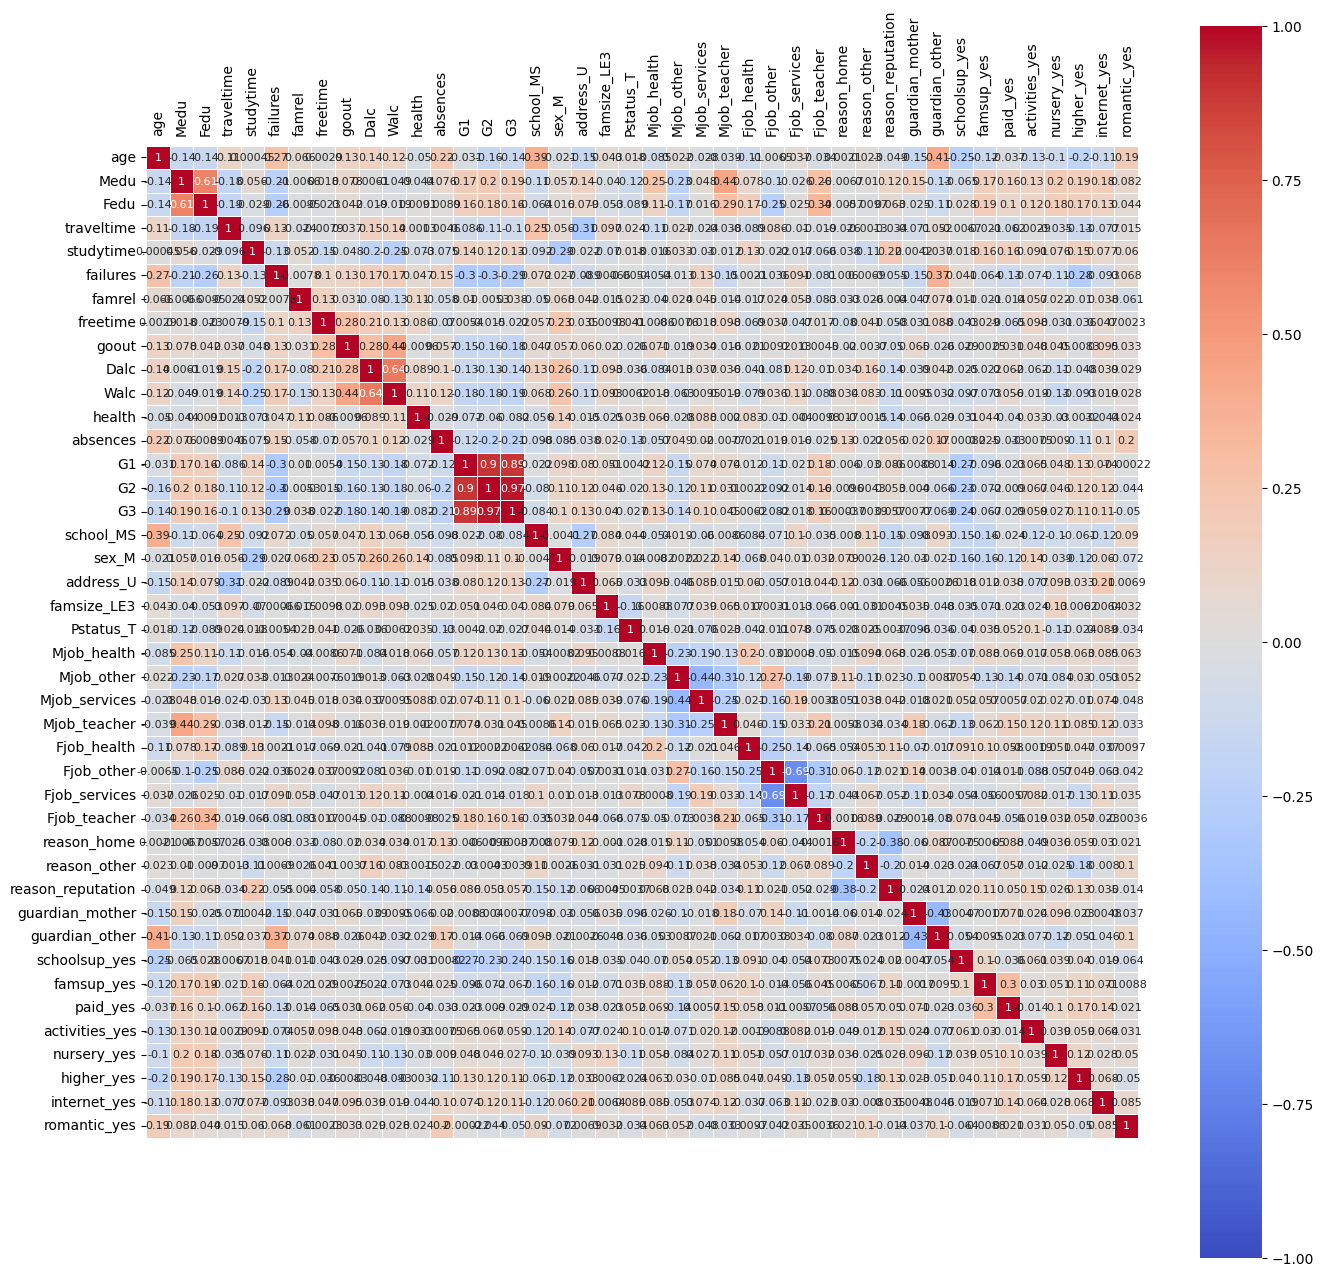

In [10]:
plt.figure(figsize=(16, 16))
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
heatmap = sns.heatmap(df_encoded.corr(), vmin=-1, vmax=1, annot=True, annot_kws={"fontsize":8}, linewidth=.5, square=True, cmap="coolwarm")

In [11]:
X = df_encoded.drop(columns='G3', axis=1)
y = df_encoded['G3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
lmod = LinearRegression()
lmod.fit(X_train, y_train)

LinearRegression()

In [13]:
y_pred = lmod.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error =", mse)
print("R-Squared =", r2)

Mean Squared Error = 0.905895323977911
R-Squared = 0.9048512570001319


In [14]:
X_train_reduced = X_train[['G1', 'G2']]
X_test_reduced = X_test[['G1', 'G2']]
lmod_reduced = LinearRegression()
lmod_reduced.fit(X_train_reduced, y_train)

y_pred = lmod_reduced.predict(X_test_reduced)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error =", mse)
print("R-Squared =", r2)

Mean Squared Error = 0.7852018658011838
R-Squared = 0.9175280316007509


We see that using just G1 and G2 as predictors yields better predictions than using all predictors, likely due to overfitting.

I'll try backward stepwise selection by iteratively removing the predictor with the lowest correlation with G3, and choose the model with the lowest MSE.

In [15]:
def best_model(predictors):
    best_preds = []
    best_mse = float('inf')
    best_r2 = 0
    while predictors:
        lmod = LinearRegression()
        lmod.fit(X_train[predictors], y_train)
        y_pred = lmod.predict(X_test[predictors])
        mse = mean_squared_error(y_test, y_pred)
        if mse < best_mse:
            best_preds = predictors[:]
            best_mse = mse
            best_r2 = r2_score(y_test, y_pred)
        predictors.pop()
    
    print("Predictors:", best_preds)
    print("Mean Squared Error =", best_mse)
    print("R-Squared =", best_r2)

In [16]:
best_model(df_encoded.corr()['G3'].abs().sort_values(ascending=False).index.tolist()[1:])

Predictors: ['G2', 'G1', 'failures', 'schoolsup_yes', 'absences', 'Medu', 'Walc', 'goout']
Mean Squared Error = 0.7518905132442883
R-Squared = 0.9210268169896589


It seems that using the above eight predictors yields the best results.

Since predicting G3 without basing the predictions on G1 and G2 can be more useful, I'll try using the same method without G1 and G2.

In [17]:
best_model(df_encoded.corr()['G3'].abs().sort_values(ascending=False).index.tolist()[3:])

Predictors: ['failures', 'schoolsup_yes', 'absences', 'Medu', 'Walc', 'goout', 'Fedu', 'Fjob_teacher', 'Mjob_other']
Mean Squared Error = 7.6476419870772725
R-Squared = 0.19674657466146805


This method yields much poorer results without using G1 and G2 as predictors. If we want to get better results, we'll likely need to take a different approach from simple linear regression.